106 ns ± 3.3 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


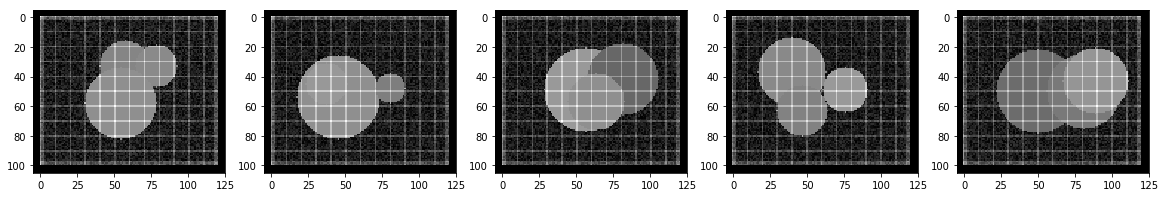

In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob, time
from collections import OrderedDict
from functools import partial
import numpy as np

from PIL import Image

from scipy.interpolate import interp2d, RectBivariateSpline,griddata
from scipy.ndimage import zoom, geometric_transform
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
import cv2

from skimage.transform import PiecewiseAffineTransform, warp, PolynomialTransform
from skimage import data

import matplotlib.pyplot as plt

import SimpleITK as sitk

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

imwidth = 100
imheight = 120
numimgs = 5


def createTestImage(width,height,numObjs=3,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height))
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=np.random.uniform(0,0.5,size=image.shape)
    
    return np.maximum(image,norm).astype(float),(image>0).astype(float)


imagemaskpairs=[createTestImage(imwidth,imheight) for _ in range(numimgs)]
    
    
def testAugment(aug):
    %timeit aug(*imagemaskpairs[0])
    fig,ax=plt.subplots(1,numimgs,figsize=(20,5))

    for i in range(numimgs):
        img,mask=imagemaskpairs[i]
        img=img.copy()
        
        # draw grid
        img[::10,:]+=0.5
        img[:,::10]+=0.5

        # draw border
        img[:3,:]+=0.5
        img[-3:,:]+=0.5
        img[:,:3]+=0.5
        img[:,-3:]+=0.5
        
        img,mask=aug(img,mask)
        ax[i].axis('on')
        ax[i].imshow(img+mask*0.5)
        ax[i].axis((-5, img.shape[1]+5, img.shape[0]+5, -5))
        ax[i].set_facecolor('black')
        
        
testAugment(lambda i,m:(i,m))

390 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


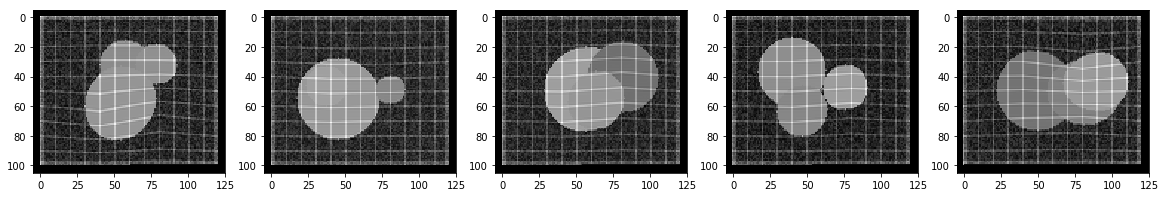

In [2]:
def deformBothInterp2D(image,mask,defrange=5):
    grid=np.zeros((4,4,2),int)
    ly=np.linspace(0,image.shape[0],grid.shape[0])
    lx=np.linspace(0,image.shape[1],grid.shape[1])
    grid[1:3,1:3,:]=np.random.randint(-defrange,defrange,(2,2,2))
    warpmap=np.zeros(image.shape+(2,))

    interx=interp2d(ly,lx,grid[...,0],'linear')
    intery=interp2d(ly,lx,grid[...,1],'linear')
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            warpmap[y,x,0]=intery(y,x).flat[0]
            warpmap[y,x,0]=interx(y,x).flat[0]
            
    def mapping(coords):
        y,x=coords[:2]
        dy,dx=warpmap[y,x,:]
        return (y+dy,x+dx)+tuple(coords[2:])    

    return geometric_transform(image,mapping),geometric_transform(mask,mapping)
    

testAugment(lambda i,m:deformBothInterp2D(i,m,5))

138 ms ± 9.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


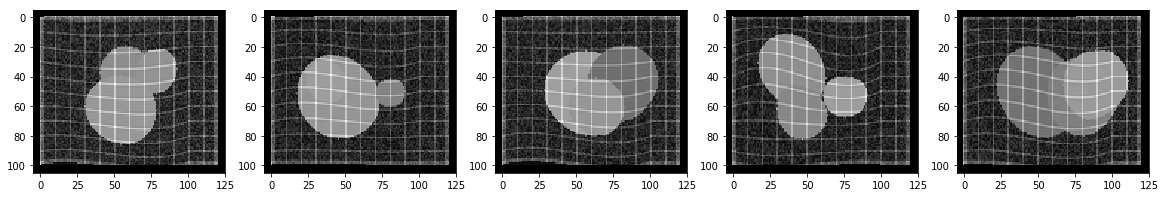

In [3]:
def deformBothAugmentRectBivariateSpline(image,mask,defrange=5):
    grid=np.zeros((4,4,2),int)
    ly=np.linspace(0,image.shape[0],grid.shape[0])
    lx=np.linspace(0,image.shape[1],grid.shape[1])
    grid[1:3,1:3,:]=np.random.randint(-defrange,defrange,(2,2,2))
    warpmap=np.zeros(image.shape+(2,))

    interx=RectBivariateSpline(lx,ly,grid[...,0])
    intery=RectBivariateSpline(lx,ly,grid[...,1])
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            warpmap[y,x,0]=intery(y,x).flat[0]
            warpmap[y,x,0]=interx(y,x).flat[0]
            
    def mapping(coords):
        y,x=coords[:2]
        dy,dx=warpmap[y,x,:]
        return (y+dy,x+dx)+tuple(coords[2:])    

    return geometric_transform(image,mapping),geometric_transform(mask,mapping)
    

testAugment(lambda i,m:deformBothAugmentRectBivariateSpline(i,m,5))

2.53 ms ± 247 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


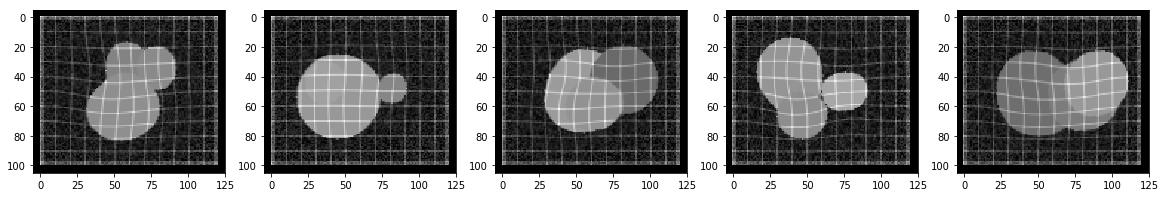

In [4]:
def deformBothAugmentSitk(image,mask,defrange=5,numSplines=4,order=2):
    dimension=image.ndim
    numControls=numSplines+order

    p=np.random.randn(dimension,numControls,numControls)*(2*defrange)-defrange

    p[:,:, 0:order] = 0
    p[:,:, -order:] = 0
    p[:,0:order, :] = 0
    p[:,-order:, :] = 0

    im=sitk.GetImageFromArray(image)
    ma=sitk.GetImageFromArray(mask)

    bspline=sitk.BSplineTransformInitializer(im,[numSplines,numSplines],order)
    bspline.SetParameters(p.flatten())

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(im)
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetDefaultPixelValue(0)
    resample.SetTransform(bspline)
    
    image=sitk.GetArrayFromImage(resample.Execute(im))
    mask=sitk.GetArrayFromImage(resample.Execute(ma))
    
    return image,mask


testAugment(lambda i,m:deformBothAugmentSitk(i,m,2))

3.7 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


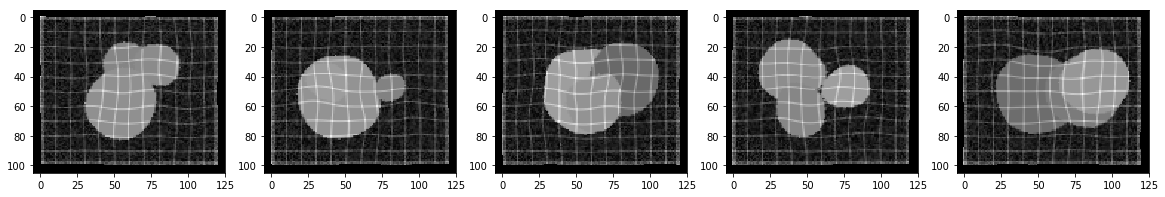

In [5]:
#https://gist.github.com/erniejunior/601cdf56d2b424757de5

def deformBothAugmentGaussian(image,mask,defrange=5,sigma=3,margin=20,random_state=None):
    random_state =random_state or np.random.RandomState(None)

    h,w = image.shape[:2]
    rmask=np.zeros((h,w))
    rmask[margin:-margin,margin:-margin]=1
    
    rx=random_state.rand(h,w) * 2 - 1
    ry=random_state.rand(h,w) * 2 - 1
    
    dx = gaussian_filter(rx*rmask, sigma, mode="constant", cval=0) * defrange
    dy = gaussian_filter(ry*rmask, sigma, mode="constant", cval=0) * defrange
    
    y, x = np.meshgrid(np.arange(w), np.arange(h))
    indices =  np.reshape(x+dx, (-1, 1)),np.reshape(y+dy, (-1, 1))

    distorted_image = map_coordinates(image, indices, order=1, mode='constant')
    distorted_mask =  map_coordinates(mask, indices, order=1, mode='constant')

    return distorted_image.reshape(image.shape[:2]),distorted_mask.reshape(image.shape[:2])

    
testAugment(lambda i,m: deformBothAugmentGaussian(i,m,100,10,20))

6.06 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


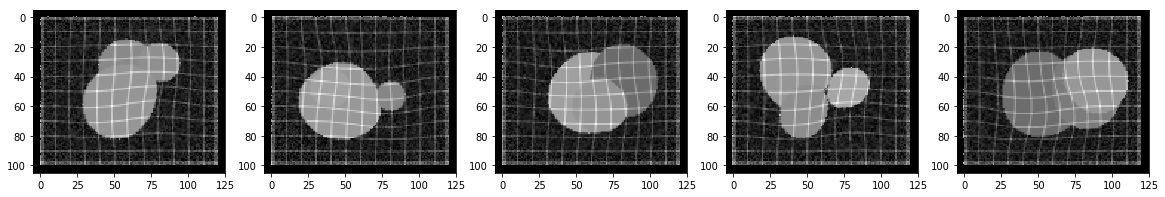

In [6]:
def deformBothAugmentZoom(image,mask,defrange=5,numControls=2,margin=1,zoomOrder=2):

    h,w = image.shape[:2]
    
    imshift=np.zeros((numControls+margin*2,numControls+margin*2,2))
    imshift[margin:-margin,margin:-margin]=np.random.randint(-defrange,defrange,(numControls,numControls,2))
    imshift=zoom(imshift,(h/imshift.shape[0],w/imshift.shape[1],1),order=zoomOrder)
        
    y, x = np.meshgrid(np.arange(w), np.arange(h))
    indices =  np.reshape(x+imshift[...,1], (-1, 1)),np.reshape(y+imshift[...,0], (-1, 1))

    distorted_image = map_coordinates(image, indices, order=1, mode='constant')
    distorted_mask =  map_coordinates(mask, indices, order=1, mode='constant')

    return distorted_image.reshape(image.shape[:2]),distorted_mask.reshape(image.shape[:2])


testAugment(lambda i,m: deformBothAugmentZoom(i,m))

1.24 ms ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


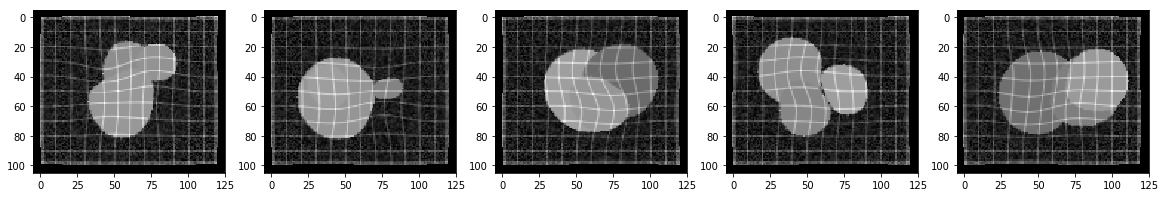

In [8]:
def deformBothAugmentPIL(image,mask,defrange=5,numControls=2,margin=1):
    h,w = image.shape[:2]
    
    imshiftx=np.zeros((numControls+margin*2,numControls+margin*2))
    imshiftx[margin:-margin,margin:-margin]=np.random.randint(-defrange,defrange,(numControls,numControls))
    imshiftx=np.array(Image.fromarray(imshiftx).resize((w,h),Image.QUAD))
    
    imshifty=np.zeros((numControls+margin*2,numControls+margin*2))
    imshifty[margin:-margin,margin:-margin]=np.random.randint(-defrange,defrange,(numControls,numControls))
    imshifty=np.array(Image.fromarray(imshifty).resize((w,h),Image.QUAD))
        
    y, x = np.meshgrid(np.arange(w), np.arange(h))
    indices =  np.reshape(x+imshiftx, (-1, 1)),np.reshape(y+imshifty, (-1, 1))

    distorted_image = map_coordinates(image, indices, order=1, mode='constant')
    distorted_mask = map_coordinates(mask, indices, order=1, mode='constant')

    return distorted_image.reshape(image.shape[:2]),distorted_mask.reshape(image.shape[:2])


testAugment(lambda i,m: deformBothAugmentPIL(i,m))

3.8 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


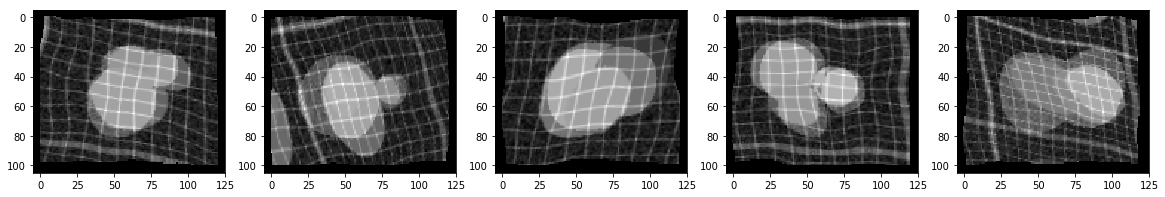

In [9]:
#https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

def deformBothAugmentCV2(image,mask,alpha,sigma=5,alpha_affine=10,random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='constant').reshape(shape),map_coordinates(mask, indices, order=1, mode='constant').reshape(shape)

    
testAugment(lambda i,m: deformBothAugmentCV2(i,m,80,10))

/home/localek10/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:812: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  warn("Bi-quadratic interpolation behavior has changed due "


16.2 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


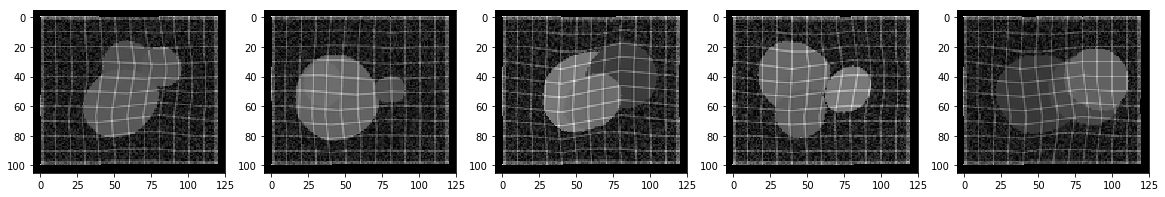

In [10]:
def deformBothAugmentSk(image,mask,defrange=5):
    rows, cols = image.shape[:2]

    src_cols = np.linspace(0, cols, 4)
    src_rows = np.linspace(0, rows, 4)
    src_rows, src_cols = np.meshgrid(src_rows, src_cols)
    src = np.dstack([src_cols.flat, src_rows.flat])[0]

    dst=src.copy()
    dst[5,:]+=np.random.randint(-defrange,defrange,(2,))
    dst[6,:]+=np.random.randint(-defrange,defrange,(2,))
    dst[9,:]+=np.random.randint(-defrange,defrange,(2,))
    dst[10,:]+=np.random.randint(-defrange,defrange,(2,))

    tform = PiecewiseAffineTransform()
    tform.estimate(src, dst)

    return warp((image*100).astype(np.int32), tform,order=2),warp(mask.astype(np.int32), tform,order=2)

testAugment(deformBothAugmentSk)